In [ ]:
from src.EDA import FaceresultssetAnalyzer
from src import config
from src.bias_assessment import (
    load_classes, load_model, get_val_loader,
    evaluate_fairness, summarize_model
)


Classes detected:
  - asian_females
  - asian_males
  - black_females
  - black_males
  - indian_females
  - indian_males
  - white_females
  - white_males

Class distribution:
asian_females: 2500
asian_males: 2500
black_females: 2500
black_males: 2500
indian_females: 2500
indian_males: 2500
white_females: 2500
white_males: 2500

Sampled 500 images for dimension analysis.
Average width: 107.8
Average height: 123.9


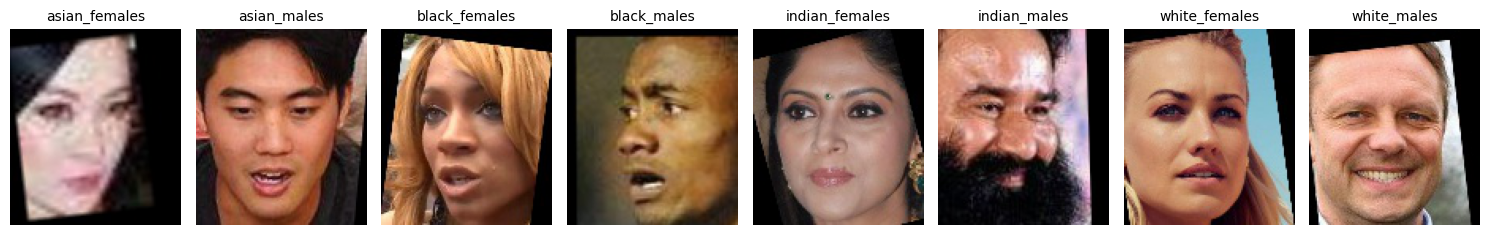

Computing mean faces: 100%|██████████| 8/8 [00:12<00:00,  1.52s/it]


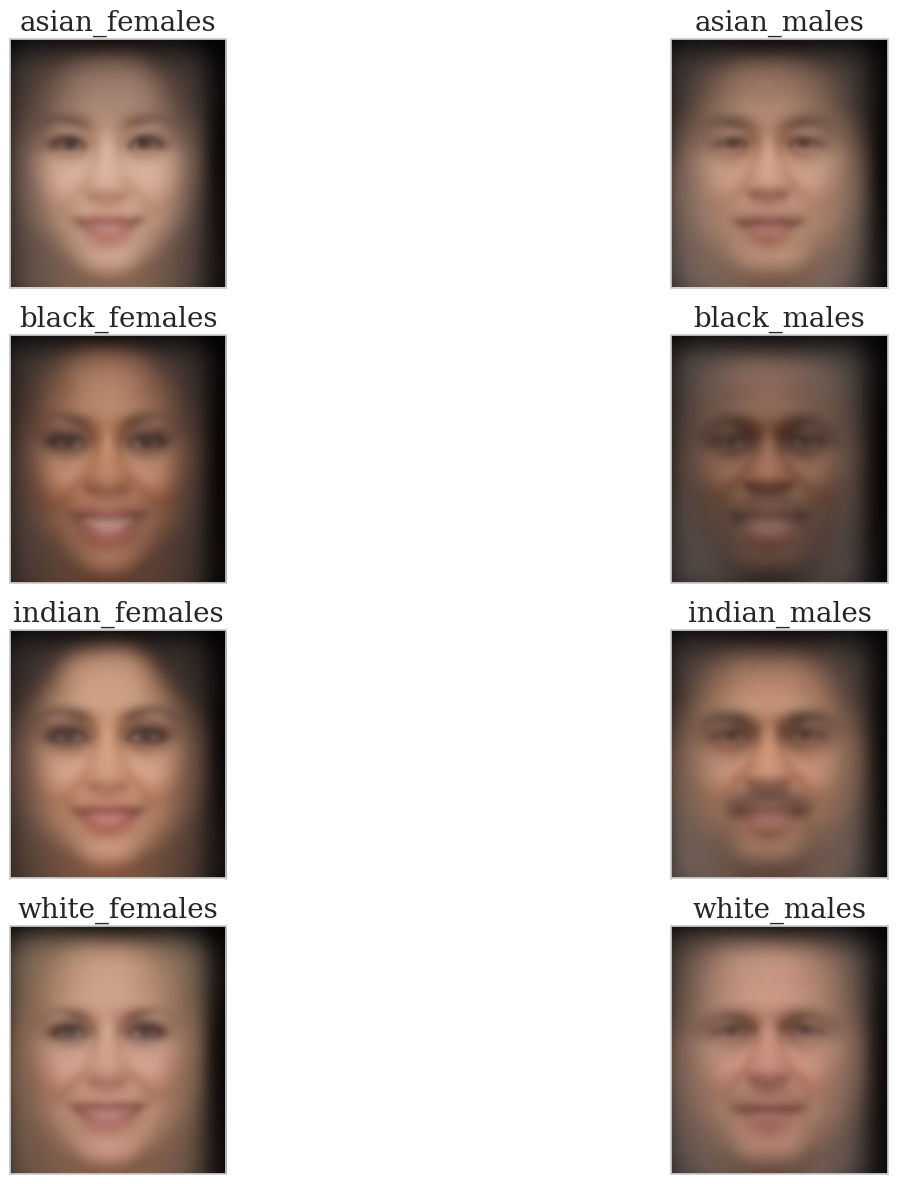

[array([[[0.04234633, 0.0368397 , 0.03668607],
         [0.04406171, 0.03836453, 0.03780364],
         [0.04694641, 0.04063319, 0.03990502],
         ...,
         [0.01480951, 0.01251964, 0.01231189],
         [0.0138348 , 0.01160839, 0.01156534],
         [0.01309172, 0.01082103, 0.01077042]],
 
        [[0.04713943, 0.04143549, 0.04057959],
         [0.04893849, 0.04305149, 0.04173973],
         [0.0531593 , 0.04655541, 0.04515948],
         ...,
         [0.01653004, 0.01424578, 0.0139087 ],
         [0.01537345, 0.01313306, 0.01289548],
         [0.01430863, 0.01203868, 0.01183158]],
 
        [[0.05460624, 0.04821336, 0.04697866],
         [0.05685142, 0.05012482, 0.04845243],
         [0.06198005, 0.05445703, 0.05269836],
         ...,
         [0.01833767, 0.01595481, 0.01552372],
         [0.01664415, 0.01431891, 0.01399428],
         [0.01527617, 0.01290634, 0.01264164]],
 
        ...,
 
        [[0.22883984, 0.19043134, 0.17443298],
         [0.24462602, 0.20432176, 0.18736

In [ ]:
results_DIR = config.results_DIR

# Or step-by-step
analyzer = FaceresultssetAnalyzer(results_DIR)
analyzer.print_classes()
analyzer.print_class_distribution()
analyzer.print_dimension_stats()
analyzer.plot_sample_images()
analyzer.plot_mean_faces()

In [ ]:
import torch

classes = load_classes(results_DIR)

# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = load_model(len(classes), "face_classifier_resnet18.pth", device)

# Summarize model
summarize_model(model)

# Load validation loader
val_loader, _ = get_val_loader(results_DIR, "val_indices.pt")

# Evaluate fairness
results = evaluate_fairness(model, val_loader, classes, device)

results

/Users/admin/Documents/Hertie/Deep Learning/tutorial-new-grp5/src/bias_assessment.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path, map_loc

{'overall_accuracy': 81.5,
 'per_class_accuracy': {'asian_females': 85.27724665391969,
  'asian_males': 77.03252032520325,
  'black_females': 79.11392405063292,
  'black_males': 91.699604743083,
  'indian_females': 81.05263157894737,
  'indian_males': 82.97029702970296,
  'white_females': 77.60617760617761,
  'white_males': 76.92307692307693},
 'accuracy_std_dev': np.float64(4.775066590959484),
 'precision': {'asian_females': 84.79087452471484,
  'asian_males': 75.64870259481037,
  'black_females': 79.44915254237289,
  'black_males': 81.54657293497364,
  'indian_females': 82.08955223880598,
  'indian_males': 79.20604914933837,
  'white_females': 88.1578947368421,
  'white_males': 81.58995815899581},
 'macro_precision': 81.55984461010675}

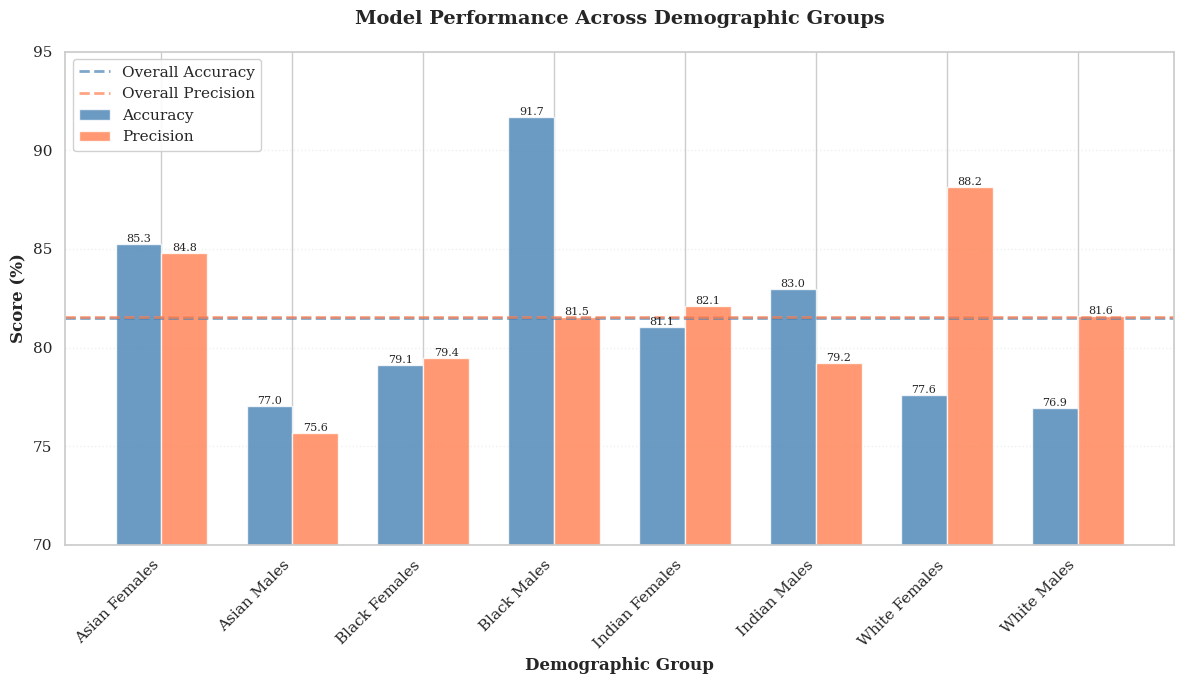

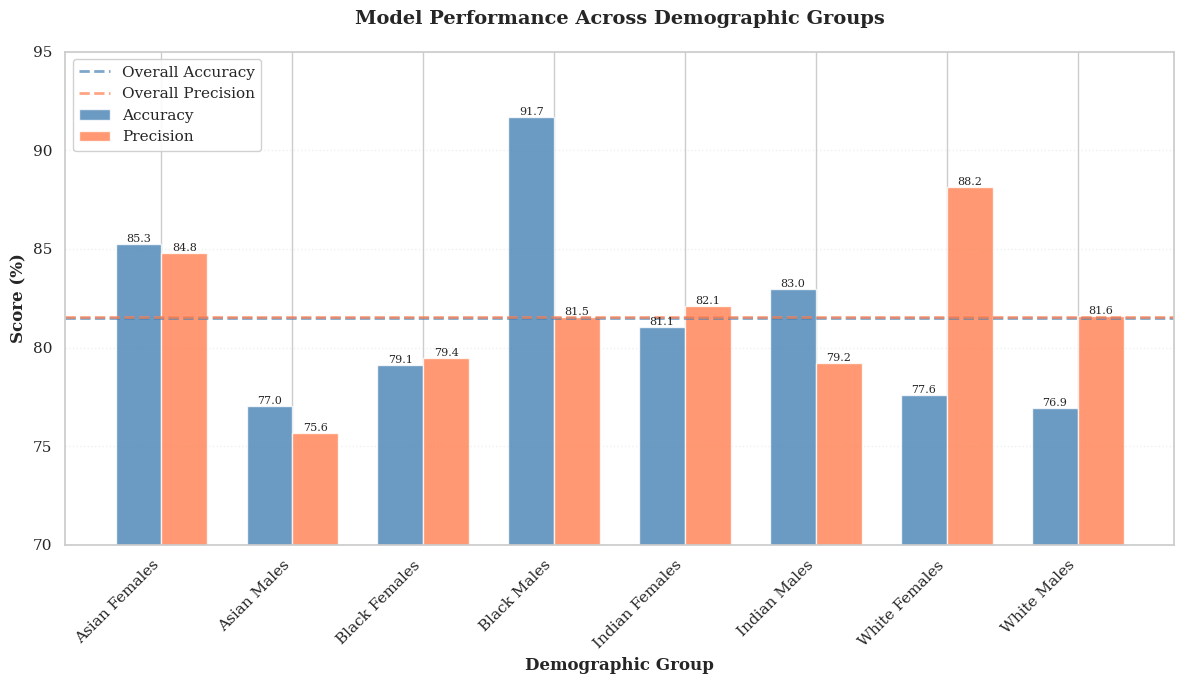

In [6]:
import matplotlib.pyplot as plt
import numpy as np


# Extract groups and values
groups = list(results['per_class_accuracy'].keys())
accuracies = list(results['per_class_accuracy'].values())
precisions = [results['precision'][group] for group in groups]

# Format group names for better readability
formatted_groups = [g.replace('_', ' ').title() for g in groups]

# Create figure
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(groups))
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', 
               color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, precisions, width, label='Precision', 
               color='coral', alpha=0.8)

# Add overall lines
ax.axhline(y=results['overall_accuracy'], color='steelblue', 
           linestyle='--', linewidth=2, label='Overall Accuracy', alpha=0.7)
ax.axhline(y=results['macro_precision'], color='coral', 
           linestyle='--', linewidth=2, label='Overall Precision', alpha=0.7)

# Customize plot
ax.set_xlabel('Demographic Group', fontsize=12, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Across Demographic Groups', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(formatted_groups, rotation=45, ha='right')
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle=':')
ax.set_ylim(70, 95)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Extract groups and values
groups = list(results['per_class_accuracy'].keys())
accuracies = list(results['per_class_accuracy'].values())
precisions = [results['precision'][group] for group in groups]

# Format group names for better readability
formatted_groups = [g.replace('_', ' ').title() for g in groups]

# Create figure
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(groups))
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', 
               color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, precisions, width, label='Precision', 
               color='coral', alpha=0.8)

# Add overall lines
ax.axhline(y=results['overall_accuracy'], color='steelblue', 
           linestyle='--', linewidth=2, label='Overall Accuracy', alpha=0.7)
ax.axhline(y=results['macro_precision'], color='coral', 
           linestyle='--', linewidth=2, label='Overall Precision', alpha=0.7)

# Customize plot
ax.set_xlabel('Demographic Group', fontsize=12, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Across Demographic Groups', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(formatted_groups, rotation=45, ha='right')
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle=':')
ax.set_ylim(70, 95)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [7]:

# Note: Using accuracy as a proxy for recall in this calculation
# F1 = 2 * (precision * recall) / (precision + recall)
# Here we're treating per_class_accuracy as recall

f1_scores = {}
for group in results['per_class_accuracy'].keys():
    precision = results['precision'][group]
    recall = results['per_class_accuracy'][group]  # Using accuracy as recall
    
    # Compute F1
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    
    f1_scores[group] = f1

# Compute macro F1
macro_f1 = np.mean(list(f1_scores.values()))

# Print results
print("F1 Scores by Demographic Group:")
print("=" * 50)
for group, f1 in f1_scores.items():
    print(f"{group:20s}: {f1:.2f}%")

print("=" * 50)
print(f"{'Macro F1':20s}: {macro_f1:.2f}%")

# Add to dictionary format
result_dict = {
    'f1_scores': f1_scores,
    'macro_f1': macro_f1
}

print("\n\nDictionary format:")
print(result_dict)

F1 Scores by Demographic Group:
asian_females       : 85.03%
asian_males         : 76.33%
black_females       : 79.28%
black_males         : 86.33%
indian_females      : 81.57%
indian_males        : 81.04%
white_females       : 82.55%
white_males         : 79.19%
Macro F1            : 81.42%


Dictionary format:
{'f1_scores': {'asian_females': 85.03336510962822, 'asian_males': 76.33434038267875, 'black_females': 79.28118393234672, 'black_males': 86.32558139534882, 'indian_females': 81.56779661016951, 'indian_males': 81.04448742746615, 'white_females': 82.54620123203286, 'white_males': 79.18781725888324}, 'macro_f1': np.float64(81.41509666856928)}
